# Deep Layout Parsing Using PaddleDetection

In this tutorial, we will show how to use the `layoutparser` API to 

1. Load Deep Learning Layout Detection models(PaddleDetection) and predict the layout of the paper image
2. Use the coordinate system to parse the output 

Make sure the environment is installed before running, please refer to：[installation.md](../installation.md)

If you want to train your own model, please refer to：[Train_PaddleDetection_model.md](../docs/notes/Train_PaddleDetection_model.md)

The `paper-image` is from https://arxiv.org/abs/2004.08686.

In [1]:
import layoutparser as lp
import cv2

## Use Layout Models to detect complex layout 

`layoutparser` can identify the layout of the given document with only 4 lines of code.

In [2]:
image = cv2.imread("data/paper-image.jpg")
image = image[..., ::-1] 
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [3]:
# TableBank Dataset
# model = lp.PaddleDetectionLayoutModel(config_path="lp://TableBank/ppyolov2_r50vd_dcn_365e_tableBank_word/config", 
#                                  threshold=0.5,
#                                  label_map={0:"Table"},
#                                  enforce_cpu=True,
#                                  enable_mkldnn=False)
    # Load the deep layout model(paddleDetection) from the layoutparser API 
    # For all the supported model, please check the Model 
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

In [4]:
# Publaynet Dataset
model = lp.PaddleDetectionLayoutModel(config_path="lp://PubLayNet/ppyolov2_r50vd_dcn_365e_publaynet/config", 
                                threshold=0.5,
                                label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                                enforce_cpu=True, 
                                enable_mkldnn=False)

Parameters description:

| parameters | Is must|description |
|-------|-------|----------|
| --config_path | Yes|config of model |
| --threshold | Option |threshold to reserve the result for output，default 0.5 |
| --input_shape  | Option |  the image shape after reshape, default [3,640,640]   |
| --batch_size | Option |test batch size,default 1 |
| --label_map | Option | The map from the model prediction (ids) to realword labels (strings), automatically get the label based on the dataset|
| --enforce_cpu | Option |whether use cpu, if False, indicates use GPU，default False|
| --enforce_mkldnn | Option |whether use mkldnn to accelerate the computation，default True|
| --thread_num | Option |the number of threads，default 10 |
| --use_dynamic_shape (bool) | No|use dynamic shape or not|
| --trt_min_shape (int) |  No| min shape for dynamic shape in trt|
| --trt_max_shape (int) |  No | max shape for dynamic shape in trt |
| --trt_opt_shape (int) |  No| opt shape for dynamic shape in trt |

You can use the ```--config_path``` to select multiple model supported by PaddleDetection:

| dataset | config_path|label_map |
|-------|-------|----------|
| TableBank word | lp://TableBank/ppyolov2_r50vd_dcn_365e_tableBank_word/config| {0:"Table"}|
| TableBank latex| lp://TableBank/ppyolov2_r50vd_dcn_365e_tableBank_latex/config | {0:"Table"}|
|  PubLayNet| lp://PubLayNet/ppyolov2_r50vd_dcn_365e_publaynet/config| {0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}|

In [5]:
layout = model.detect(image)
    # Detect the layout of the input image

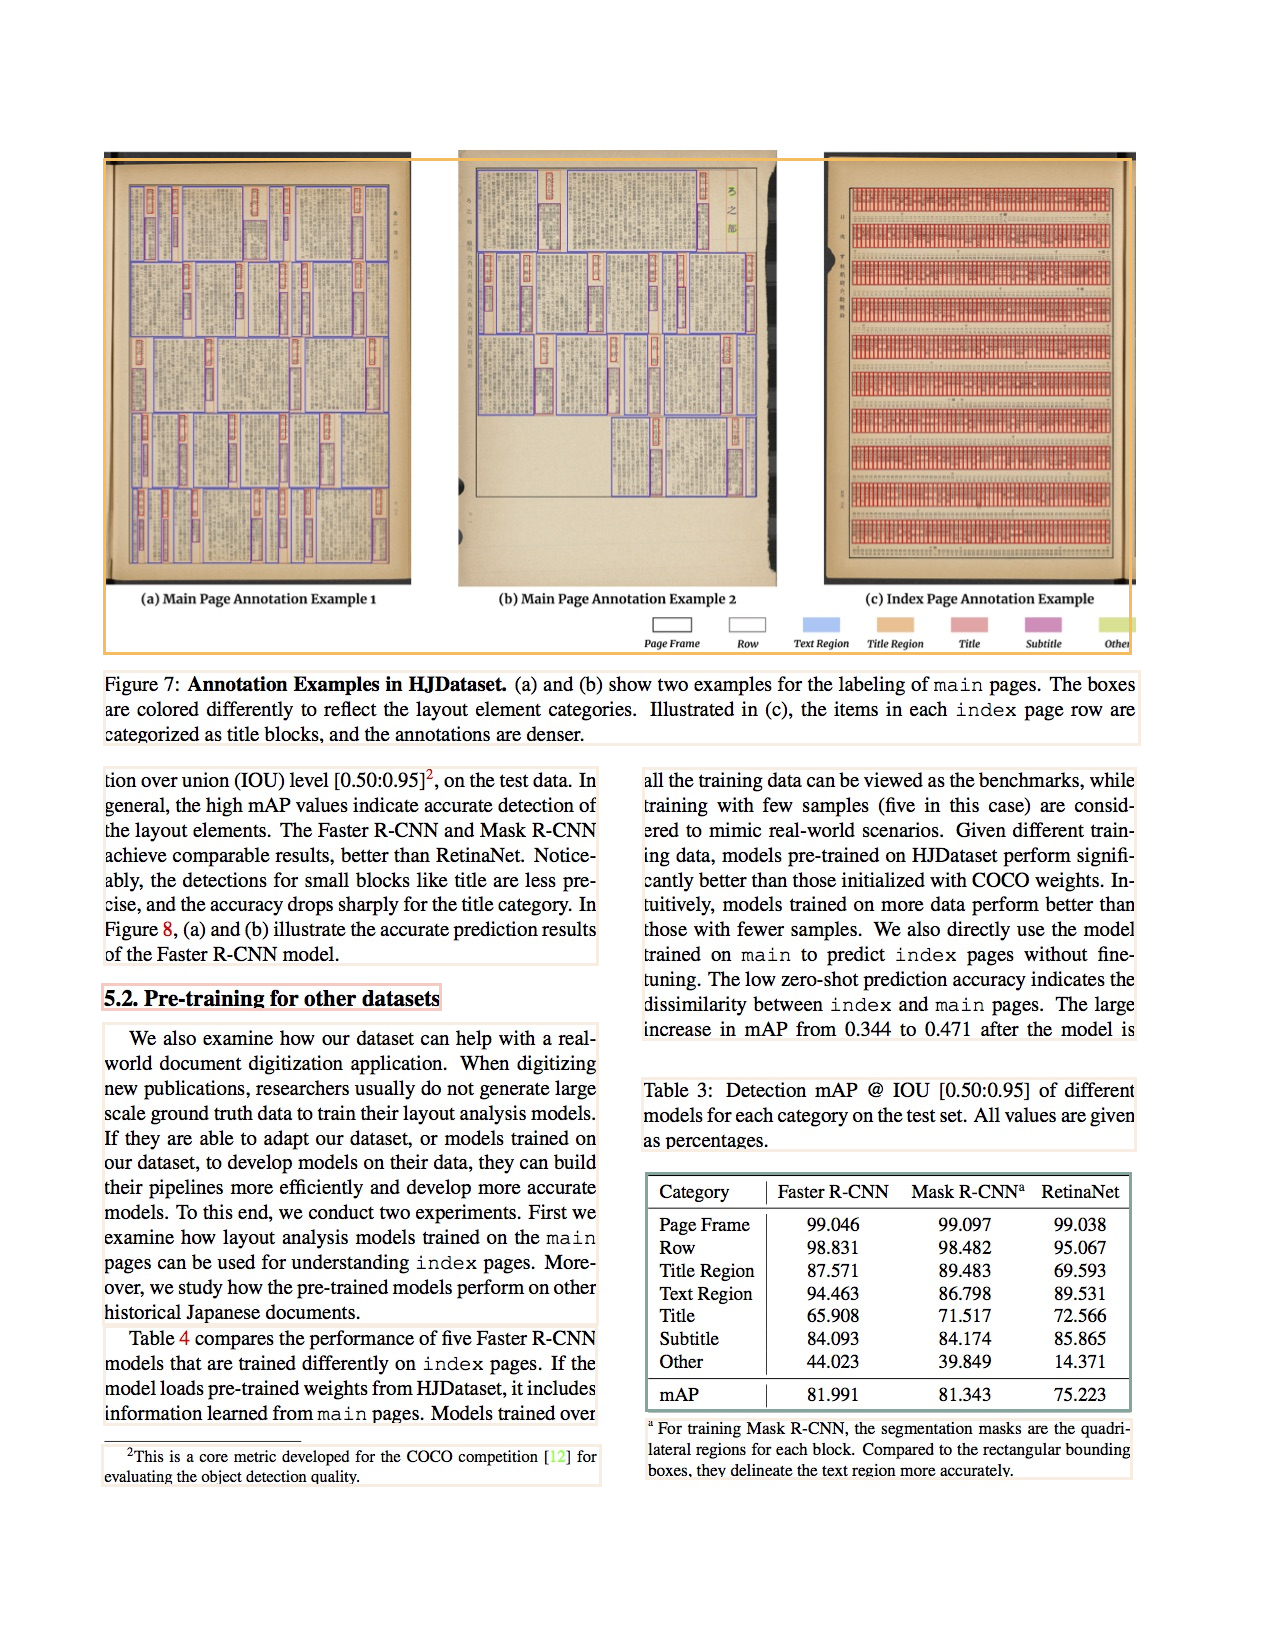

In [6]:
lp.draw_box(image, layout, box_width=3)
    # Show the detected layout of the input image

## Check the results from the model 

In [7]:
type(layout)         

layoutparser.elements.Layout

The `layout` variables is a `Layout` instance, which is inherited from list and supports handy methods for layout processing. 

In [8]:
layout[0]

TextBlock(block=Rectangle(x_1=102.72477722167969, y_1=1022.0228881835938, x_2=598.1790161132812, y_2=1325.096435546875), text=None, id=None, type=Text, parent=None, next=None, score=0.9880033731460571)

`layout` contains a series of `TextBlock`s. They store the coordinates in the `.block` variable and other information of the blocks like block type in `.type`, text in `.text`, etc. More information can be found at the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/elements.html#layoutparser.elements.TextBlock). 

## Use the coordinate system to process the detected layout

Firstly we filter text region of specific type:

In [9]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As there could be text region detected inside the figure region, we just drop them:

In [10]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally sort the text regions and assign ids: 

In [11]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

Visualize the cleaned text blocks:

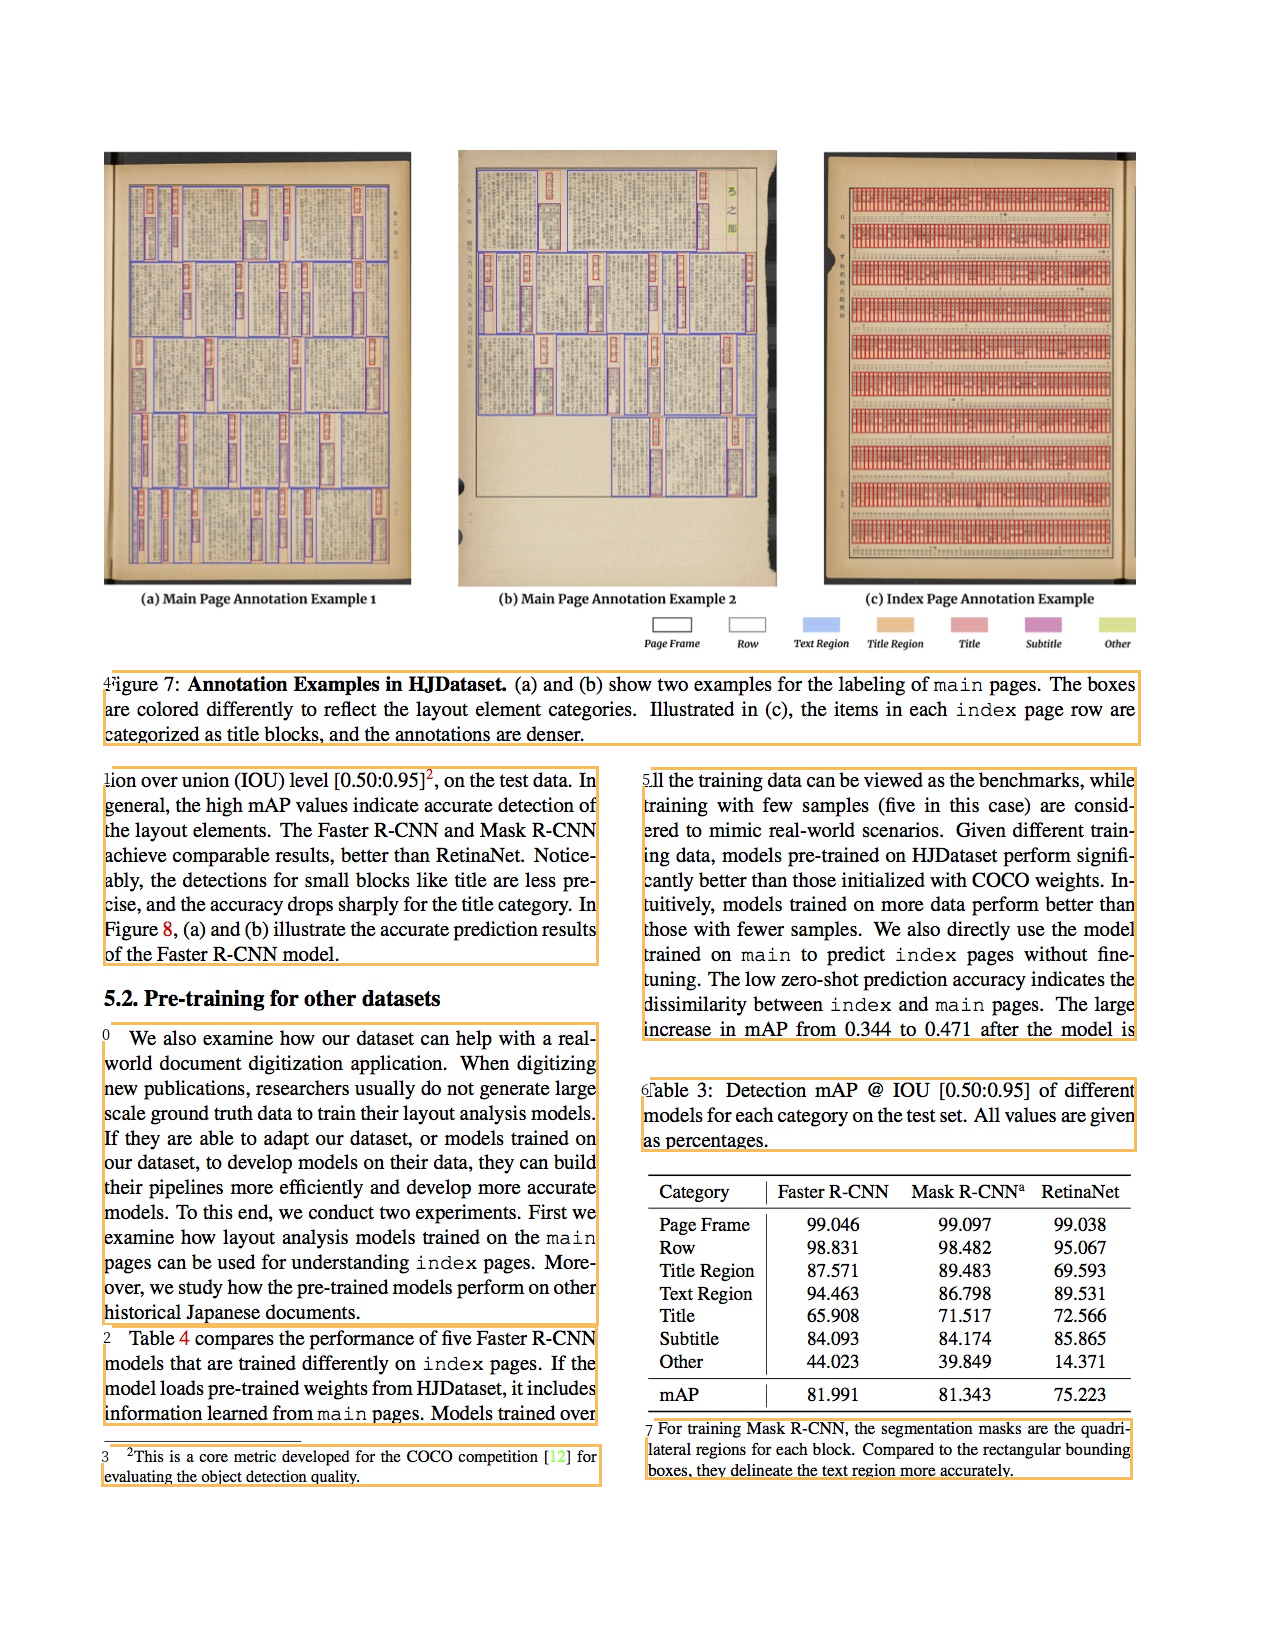

In [12]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

## Fetch the text inside each text region

We can also combine with the OCR functionality in `layoutparser` to fetch the text in the document. 

In [14]:
ocr_agent = lp.PaddleocrAgent(languages='ch',use_gpu=False)  
    # Initialize the paddleocr engine. You might need 
    # to install the OCR components in layoutparser:
    # ！pip install layoutparser[ocr]

Namespace(cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/Users/anmengtao/.paddleocr/2.1/cls', cls_thresh=0.9, det=True, det_algorithm='DB', det_db_box_thresh=0.5, det_db_thresh=0.3, det_db_unclip_ratio=1.6, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/Users/anmengtao/.paddleocr/2.1/det/ch', drop_score=0.5, enable_mkldnn=False, gpu_mem=8000, image_dir='', ir_optim=True, label_list=['0', '180'], lang='ch', max_text_length=25, rec=True, rec_algorithm='CRNN', rec_batch_num=6, rec_char_dict_path='./ppocr/utils/ppocr_keys_v1.txt', rec_char_type='ch', rec_image_shape='3, 32, 320', rec_model_dir='/Users/anmengtao/.paddleocr/2.1/rec/ch', use_angle_cls=False, use_dilation=False, use_gpu=False, use_pdserving=False, use_space_char=True, use_tensorrt=False, use_zero_copy_run=False)


In [15]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image) 
    block.set(text=text, inplace=True)

[2021/06/08 16:12:09] root INFO: dt_boxes num : 12, elapse : 0.5430939197540283
[2021/06/08 16:12:10] root INFO: rec_res num  : 12, elapse : 0.6878690719604492
[2021/06/08 16:12:11] root INFO: dt_boxes num : 12, elapse : 0.9645383358001709
[2021/06/08 16:12:11] root INFO: rec_res num  : 12, elapse : 0.5320448875427246
[2021/06/08 16:12:13] root INFO: dt_boxes num : 26, elapse : 1.8096749782562256
[2021/06/08 16:12:14] root INFO: rec_res num  : 26, elapse : 0.3690009117126465
[2021/06/08 16:12:19] root INFO: dt_boxes num : 17, elapse : 5.0040669441223145
[2021/06/08 16:12:19] root INFO: rec_res num  : 17, elapse : 0.2210860252380371
[2021/06/08 16:12:25] root INFO: dt_boxes num : 49, elapse : 5.274165868759155
[2021/06/08 16:12:25] root INFO: rec_res num  : 49, elapse : 0.5300133228302002
[2021/06/08 16:12:26] root INFO: dt_boxes num : 11, elapse : 0.5410220623016357
[2021/06/08 16:12:26] root INFO: rec_res num  : 11, elapse : 0.6773760318756104
[2021/06/08 16:12:29] root INFO: dt_boxes

In [16]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

We also examine how our dataset can helpwith a real-
world document digitization application.When digitizing
new publications，researchers usually do not generate large
scaleground truth data to train their layout analysis models
Ifthey are able toadaptourdataset，or models trainedon
ourdataset，to develop models on their data，they can build
their pipelines more efificiently and develop more accurate
models.Tothisend.weconducttwoexperiments.Firstwe
examine how layout analysis models trained on the main
pages can be used for understanding index pages. More-
over，we study how thepre-trained models perform on other
historical Japanese documents.
---
tion overunion
（IOU）level 0.50:0.9512
onthe testdata.In
general.
the high mAPvalues indicate accurate detection of
thelayout elements.The Faster R-CNNand Mask R-CNN
achieve comparable results，better than RetinaNet.Notice-
ably，the detections for small blocks like title are less pre-
Cise，andtheaccuracy
drops sharply for the title category.In
Figu

### Compare Detectron2 and PaddleDetection layoutparser model:

PublayNet Dataset:

| Model | mAP|CPU time cost |GPU time cost |
|-------|-------|----------|----------|
| Detectron2| 88.99%| 16545.5ms| 209.5ms|
| PaddleDetection | 93.6%| 1713.7ms| 66.6ms|

TableBank Dataset:

| Model | mAP|CPU time cost |GPU time cost |
|-------|-------|----------|----------|
| Detectron2| 89.78%| 7623.2ms| 104.2.ms|
| PaddleDetection | 96.2%| 1968.4ms| 65.1ms|

**Envrionment：**	

​	**GPU：** a single NVIDIA Tesla P40

​	**CPU：**  Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz，24core